In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy import interpolate
import torch
import torch.nn as nn
torch.manual_seed(0)
np.random.seed(0)
torch.set_default_tensor_type(torch.DoubleTensor)
torch.set_default_dtype(torch.float64)

In [2]:
def DEIM(U):
    """
    Compute DEIM interpolation indices given
    U = {u_i}_i matrix with linearly independent columns.
    """
    U = np.copy(U)
    selected_indices = []
    
    for i in range(U.shape[1]):
        idx = np.argmax(np.abs(U[:, i]))
        selected_indices.append(idx)
        U = U - 1/U[idx, i] * U[:, [i]] @ U[[idx], :]
    
    return selected_indices

In [3]:
def Exact_NEIM(mu, f, U, max_modes=25):
    """
    Compute a non-neural network NEIM for solution
    independent nonlinearities.
    
    mu: parameters
    f:  nonlinearity corresponding to each mu in a matrix
    U:  POD basis
    """
    
    Pf = U.T @ f # projection of f
    
    selected_parameters = []
    selected_indices = []
    trained_networks = []
    
    # NEIM Step 1
    idx = np.argmax([np.linalg.norm(Pf[:, i])**2 for i in range(Pf.shape[1])])
    mu_1 = mu[idx]
    selected_parameters.append(mu_1)
    selected_indices.append(idx)
    
    NN_1 = np.copy(Pf[:, [idx]])
    NN_1 /= np.linalg.norm(NN_1)
    trained_networks.append(NN_1)
    thetas = np.array([np.dot(NN_1.reshape(-1), Pf[:, i])/np.linalg.norm(NN_1)**2 for i in range(Pf.shape[1])])
    current_approximation = thetas * NN_1
    
    # NEIM Update Step
    for i in range(1, max_modes):
        idx = np.argmax([np.linalg.norm(current_approximation[:, i] - Pf[:, i])**2 for i in range(Pf.shape[1])])
        mu_i = mu[idx]
        selected_parameters.append(mu_i)
        selected_indices.append(idx)
        
        # orthogonalize selected vector with respect to previous vectors
        NN_i = Pf[:, [idx]]
        for network in trained_networks:
            NN_i -= np.dot(NN_i.reshape(-1), network.reshape(-1)) * network / np.linalg.norm(network)**2
        NN_i /= np.linalg.norm(NN_i)
        
        trained_networks.append(NN_i)
        A = np.zeros((i+1, i+1))
        for j in range(A.shape[0]):
            for k in range(A.shape[1]):
                A[j, k] = np.dot(trained_networks[j].reshape(-1), trained_networks[k].reshape(-1))
        
        thetas = []
        for j in range(Pf.shape[1]):
            b = np.zeros((i+1, 1))
            for k in range(b.shape[0]):
                b[k, 0] = np.dot(trained_networks[k].reshape(-1), Pf[:, j])
            thetas.append(np.linalg.solve(A, b).reshape(-1))
        thetas = np.array(thetas).T
        current_approximation = np.array(trained_networks)[:, :, 0].T @ thetas
    
    trained_networks = np.array(trained_networks)[:, :, 0].T
    
    def Exact_NEIM_approximation(new_mu, num_modes=-1):
        if num_modes == -1:
            num_modes = trained_networks.shape[1]
        thetas_ = interpolate.griddata(mu, thetas.T, new_mu, method='cubic').reshape(-1, 1)
        if True in np.isnan(thetas_):
            thetas_ = interpolate.griddata(mu, thetas.T, new_mu, method='nearest').reshape(-1, 1)
        return U @ (trained_networks[:, :num_modes] @ thetas_[:num_modes])
    
    return Exact_NEIM_approximation, selected_indices

In [4]:
# Note that in the example, there is no actual input for
# the neural network. Instead, to simulate NEIM, we will
# choose a simple "solution".

def solution_fn(mu, f):
    # compute full order solutions
    sols = np.zeros((mu.shape[0], f.shape[0]), dtype=np.double)
    A = 2*np.eye(f.shape[0], dtype=np.double) - np.eye(f.shape[0], k=1, dtype=np.double) - np.eye(f.shape[0], k=-1, dtype=np.double)
    A = 30 * A
    A = A[1:-1, 1:-1]
    
    for i, m in enumerate(mu): # loop over parameters for nonlinearity
        sol = np.zeros((f.shape[0], 1), dtype=np.double)
        sol[1:-1] = np.linalg.solve(A, f[1:-1, [i]])
        sol = sol.reshape(-1)
        sols[i] = sol
            
    return sols

class Net(nn.Module):
    def __init__(self, in_size, out_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(in_size, 1)
        self.fc3 = nn.Linear(1, out_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = torch.tanh(x)
        x = self.fc3(x)
        return x

def NEIM(ro_sols, f_NEIM, mu, V, max_modes=10, train_loop_iterations=10000):
    """
    Compute NEIM for solution
    independent nonlinearities.
    """
    NUM_PARAMS = f_NEIM.shape[0]
    RO_DIM = ro_sols.shape[1]
    
    selected_indices = []
    trained_networks = []
    
    # NEIM Step 1
    errors = np.zeros(NUM_PARAMS)
    for i in range(NUM_PARAMS):
        # compute error
        s = 0
        for j in range(NUM_PARAMS):
            s += np.sum(f_NEIM[i, j]**2)
        errors[i] = s / NUM_PARAMS
    
    idx = np.argmax(errors)
    selected_indices.append(idx)
    print(idx, "Max Error:", errors[idx], "Mean Error:", np.mean(errors))
    
    Network_mu_1 = Net(RO_DIM, RO_DIM)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(Network_mu_1.parameters(), lr=0.001)
    #scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9999)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.9)
    
    x_data = torch.tensor(ro_sols, dtype=torch.double)
    y_data = torch.tensor(np.array([f_NEIM[idx, j]/np.linalg.norm(f_NEIM[idx, j]) for j in range(f_NEIM.shape[1])]), dtype=torch.double)
    
    for epoch in range(train_loop_iterations):
        optimizer.zero_grad()
        output = Network_mu_1(x_data)
        loss = criterion(output, y_data)
        if epoch % 100 == 0:
            print(epoch, loss.item())
        loss.backward()
        optimizer.step()
        #scheduler.step()
        scheduler.step(loss)
    
    Network_mu_1.eval()
    trained_networks.append(Network_mu_1)
    
    thetas = np.zeros((NUM_PARAMS, 1), dtype=np.double)
    for i in range(NUM_PARAMS):
        numerator = 0
        denominator = 0
        for j in range(NUM_PARAMS):
            net_u_mu = Network_mu_1(x_data[j].view(1, -1)).detach().numpy().reshape(-1)
            numerator += np.dot(f_NEIM[i, j], net_u_mu)
            denominator += np.dot(net_u_mu, net_u_mu)

        theta_1_1_i = numerator / denominator
        thetas[i] = theta_1_1_i    
    
    for iteration in range(max_modes-1):
        # current approximation
        approx = lambda sol, param_idx: sum([
            thetas[param_idx][i] * net(torch.tensor(sol).view(1, -1)).T.detach().numpy().reshape(-1)\
            for i, net in enumerate(trained_networks)
        ])
    
        
        errors = np.zeros(NUM_PARAMS)
        for i in range(NUM_PARAMS):
            # compute error
            s = 0
            for j in range(NUM_PARAMS):
                s += np.sum((f_NEIM[i, j] - approx(ro_sols[j], i))**2)
            errors[i] = s / NUM_PARAMS
    
        errors[np.array(selected_indices)] = -1
        mu_2_idx = np.argmax(errors)
        selected_indices.append(mu_2_idx)
        print(mu_2_idx, "Max Error:", errors[mu_2_idx], "Mean Error:", np.mean(errors[errors>=0]))
        
        Network_mu_2 = Net(RO_DIM, RO_DIM)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(Network_mu_2.parameters(), lr=0.001)
        #scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9999)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.9)


        # need to do Gram-Schmidt on this matrix
        y_data = np.copy(f_NEIM[mu_2_idx])
        
        for net in trained_networks:
            # form matrix of evaluations for this network
            previous_net_matrix = np.zeros((NUM_PARAMS, f_NEIM.shape[2]), dtype=np.double)
            for i in range(NUM_PARAMS):
                previous_net_matrix[i] = net(x_data[i].view(1, -1)).detach().numpy().reshape(-1)
                y_data[i] -= np.dot(y_data[i], previous_net_matrix[i]) * previous_net_matrix[i] / np.linalg.norm(previous_net_matrix[i])**2
        
        for j in range(f_NEIM.shape[1]):
            y_data[j] = y_data[j] / np.linalg.norm(y_data[j])
        
        y_data = torch.tensor(y_data)
        
        for epoch in range(train_loop_iterations):
            optimizer.zero_grad()
            output = Network_mu_2(x_data)
            loss = criterion(output, y_data)
            if epoch % 100 == 0:
                print(epoch, loss.item())
            loss.backward()
            optimizer.step()
            #scheduler.step()
            scheduler.step(loss)

        Network_mu_2.eval()
        trained_networks.append(Network_mu_2)
        
        # 3c. Find theta_1_2(mu), theta_2_2(mu)
        print("\nFinding theta...")
        num_nets = len(trained_networks)
        thetas = np.zeros((NUM_PARAMS, num_nets), dtype=np.double)
        for i in range(NUM_PARAMS):
            LHS_numerator = np.zeros((num_nets, num_nets), dtype=np.double)
            LHS_denominator = np.zeros((num_nets, num_nets), dtype=np.double)
            RHS_numerator = np.zeros((num_nets, 1), dtype=np.double)
            RHS_denominator = np.zeros((num_nets, 1), dtype=np.double)

            for j in range(NUM_PARAMS):
                nets_u_mu = [net(x_data[j].view(1, -1)).detach().numpy().reshape(-1) for net in trained_networks]

                for k1 in range(num_nets):
                    RHS_numerator[k1] += np.dot(f_NEIM[i, j], nets_u_mu[k1])
                    RHS_denominator[k1] += np.dot(nets_u_mu[k1], nets_u_mu[k1])
                    for k2 in range(num_nets):
                        LHS_numerator[k1, k2] += np.dot(nets_u_mu[k1], nets_u_mu[k2])
                        LHS_denominator[k1, k2] += np.dot(nets_u_mu[k1], nets_u_mu[k1])

            LHS = LHS_numerator / LHS_denominator
            RHS = RHS_numerator / RHS_denominator
            thetas[i] = np.linalg.solve(LHS, RHS).reshape(-1)
        
    def NEIM_approximation(new_mu, new_sol, num_modes=-1):
        if num_modes == -1:
            num_modes = len(trained_networks)
        
        new_sol = torch.tensor(new_sol)
        thetas_ = interpolate.griddata(mu, thetas, new_mu, method='cubic').reshape(-1)
        if True in np.isnan(thetas_):
            thetas_ = interpolate.griddata(mu, thetas, new_mu, method='nearest').reshape(-1)
        s = 0
        for i, net in enumerate(trained_networks[:num_modes]):
            s += thetas_[i] * net(new_sol.view(1, -1)).view(-1).detach().numpy()
        return (V @ s.reshape(-1, 1)).reshape(-1)
    
    return NEIM_approximation, selected_indices

# Nonlinear parameterized function with spatial points in one dimension
Example from DEIM paper section 3.3.1:

We have a nonlinear parameterized function $s:\Omega\times\mathcal{D}\to\mathbb{R}$ defined by $$s(x;\mu) = (1-x)\cos(3\pi\mu(x+1))e^{-(1+x)\mu},$$ where $\Omega = [-1, 1]$ and $\mu\in\mathcal{D} = [1,\pi]$.

Let $\boldsymbol{x} = [x_1,\dots,x_n]^\top\in\mathbb{R}^n$ with $x_i$ equidistantly spaced points in $\Omega$ for $i=1,\dots,n$, $n=100$. Define $f:\mathcal{D}\to\mathbb{R}^n$ by $$f(\mu) = [s(x_1;\mu),\dots,s(x_n;\mu)]^\top\in\mathbb{R}^n$$ for $\mu\in\mathcal{D}$. 

We then use 51 snapshots $f(\mu_j)$ to construct a POD basis $\{u_\ell\}_{\ell=1}^m$, with $\mu_1,\dots,\mu_{51}$ selected as equally spaced points in $[1,\pi]$.

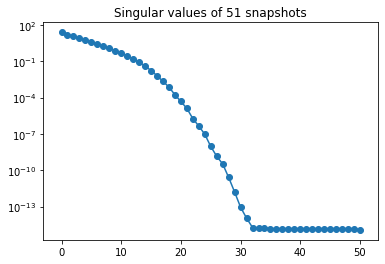

In [5]:
def s(x, mu):
    return (1-x)*np.cos(3*np.pi*mu*(x+1))*np.exp(-(1+x)*mu)

x = np.linspace(-1, 1, 100).reshape(-1,1)
mu = np.linspace(1, np.pi, 51).reshape(-1,1).T
f = s(x, mu) # shape = (space, parameters)

u, sing_vals, vh = np.linalg.svd(f, full_matrices=True)
plt.plot(np.arange(sing_vals.shape[0]), sing_vals)
plt.scatter(np.arange(sing_vals.shape[0]), sing_vals)
plt.yscale("log")
plt.title("Singular values of 51 snapshots")
plt.show()

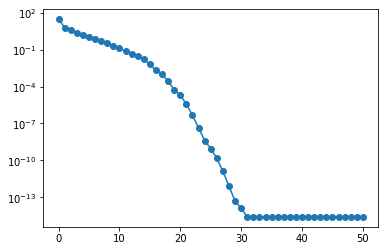

(100, 51)


In [6]:
RO_DIM = 30

# find solution to Poisson with homogeneous Dirichlet boundary conditions
# -u''(x; mu) = s(x; mu), u(0; mu) = u(1; mu) = 0.

sols = solution_fn(mu.reshape(-1), f) # shape = (params, space)

# do a POD based on sols
snapshots = np.array([sols[i] for i in range(sols.shape[0])]).T
V, sing_vals, _ = np.linalg.svd(snapshots, full_matrices=False)

plt.scatter(np.arange(sing_vals.shape[0]), sing_vals)
plt.semilogy(np.arange(sing_vals.shape[0]), sing_vals)
plt.show()
print(V.shape)

# get reduced order solutions
ro_sols = np.zeros((sols.shape[0], RO_DIM))
for i in range(sols.shape[0]):
    ro_sols[i] = (V[:,:RO_DIM].T @ sols[i].reshape(-1, 1)).reshape(-1)

# evaluate nonlinearity at given parameter and solution
f_NEIM = np.zeros((sols.shape[0], sols.shape[0], RO_DIM))
for i in range(sols.shape[0]):
    for j in range(sols.shape[0]):
        f_NEIM[i, j] = (V[:,:RO_DIM].T @ f[:, [i]]).reshape(-1)

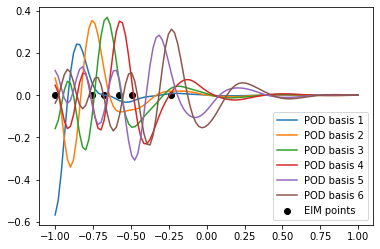

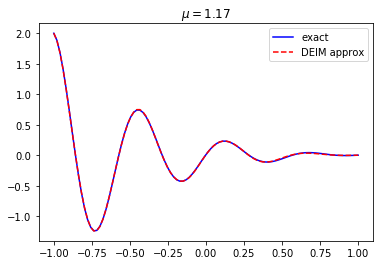

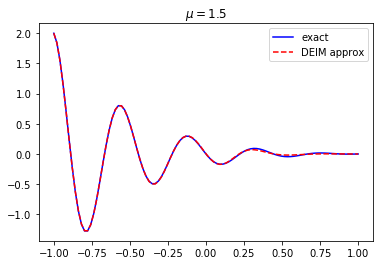

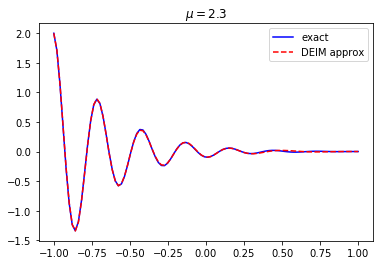

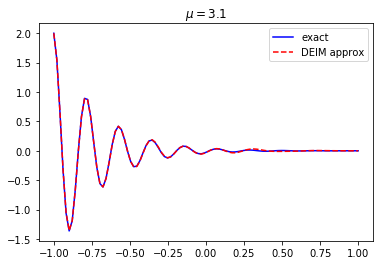

In [7]:
# Get DEIM indices
selected_indices = DEIM(u)

# plot POD basis vectors and first six spatial points
plt.scatter(x[selected_indices[:6]], np.zeros(6), c='black', label="EIM points")
for i in range(6):
    plt.plot(x, u[:, i], label=f"POD basis {i+1}")
plt.legend()
plt.show()

# look at DEIM approximations for these mu values and 10 DEIM modes
test_mu = [1.17, 1.5, 2.3, 3.1]
s_op = np.zeros((f.shape[0], 10)) # selection operator
for i, idx in enumerate(selected_indices[:10]):
    s_op[idx, i] = 1
DEIM_proj = u[:, :10] @ np.linalg.inv(s_op.T @ u[:, :10]) @ s_op.T # DEIM projection
for mu_val in test_mu:
    exact = s(x, mu_val)
    DEIM_approximation = DEIM_proj @ exact
    
    plt.plot(x, exact, label="exact", c='b')
    plt.plot(x, DEIM_approximation, label="DEIM approx", c='r', linestyle="dashed")
    plt.title(f"$\mu = {mu_val}$")
    plt.legend()
    plt.show()

# Compare Errors for POD, DEIM, Exact NEIM
Exact NEIM is the version of NEIM for nonlinearities which do not depend on solutions (they depend on space and parameters). In this case, NEIM should approximate constant vectors in its expansion, so we can instead use these exact vectors.

**If you want better results for Exact NEIM, increase NUM_TRAIN_PARAMS**

[0, 13, 30, 50, 6]
0 Max Error: 29.330188202753714 Mean Error: 17.993265559847828
0 0.3742892596664328
100 0.22442247468688598
200 0.15410203922457458
300 0.10845794160525447
400 0.07545076560930451
500 0.05125470131649919
600 0.03387220678572408
700 0.021675172129762763
800 0.013363244200816537
900 0.007907963353641549
1000 0.004484700671688557
1100 0.002438745687688601
1200 0.0012735785144812057
1300 0.000639350825157969
1400 0.00030845013349599626
1500 0.00014280309930198953
1600 6.330713239518963e-05
1700 2.680477528587718e-05
1800 1.080918077127067e-05
1900 4.138866661674324e-06
2000 1.4999366191748613e-06
2100 5.127070369837578e-07
2200 1.6470154523888685e-07
2300 4.9543426061402655e-08
2400 1.3914256657515455e-08
2500 3.6507262974080328e-09
2600 9.097225393376358e-10
2700 2.337181490197383e-10
2800 7.997307815072549e-11
2900 4.735551569036045e-11
3000 4.0402909559993355e-11
3100 3.842460882067271e-11
3200 3.735379744453103e-11
3300 3.646545620743599e-11
3400 3.563935187608451e-1

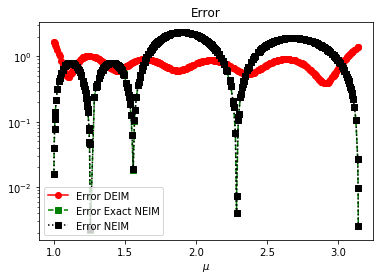

[0, 13, 30, 50, 6, 21, 39, 3, 25, 45]
0 Max Error: 29.330188202753714 Mean Error: 17.993265559847828
0 0.47350903076592205
100 0.32206861467299946
200 0.2252454525420982
300 0.14742503040713045
400 0.09011012543853096
500 0.052568109184061976
600 0.02929739748122965
700 0.015484896803048084
800 0.007726199643979869
900 0.0036431294708882075
1000 0.0016303270021199242
1100 0.0006949233233985209
1200 0.00028243344465529247
1300 0.00010929371369625106
1400 4.0149121963179476e-05
1500 1.3947832419634191e-05
1600 4.562977039408169e-06
1700 1.3993944240014988e-06
1800 4.004367222791276e-07
1900 1.0640458731531699e-07
2000 2.6144993874861237e-08
2100 5.934579582482829e-09
2200 1.2632856009230278e-09
2300 2.7555382901405944e-10
2400 8.327966518159003e-11
2500 4.6800215526564435e-11
2600 3.8076743255911154e-11
2700 3.40690322860997e-11
2800 3.104888856363242e-11
2900 2.845220737579213e-11
3000 2.6175540348301872e-11
3100 2.417676878277686e-11
3200 2.2423363161916667e-11
3300 2.0886441240776103e

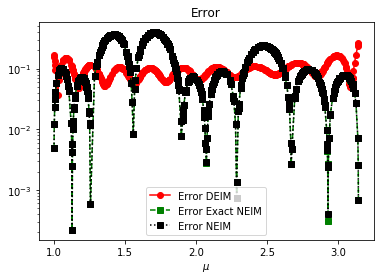

[0, 13, 30, 50, 6, 21, 39, 3, 25, 45, 16, 35, 9, 48, 1]
0 Max Error: 29.330188202753714 Mean Error: 17.993265559847828
0 0.3936875568690778
100 0.27928804730389445
200 0.17848559100168104
300 0.10276416071617336
400 0.0549215255796322
500 0.027503352904796132
600 0.012760203723872827
700 0.005404122156581495
800 0.0020668574699245113
900 0.0007119317021813855
1000 0.0002218402401987334
1100 6.306813254216419e-05
1200 1.6511820575255943e-05
1300 4.011035560750844e-06
1400 9.076391030855e-07
1500 1.9131200018263466e-07
1600 3.7482884442394755e-08
1700 6.864072991476325e-09
1800 1.2462279417449134e-09
1900 2.957164316043458e-10
2000 1.4200644824243395e-10
2100 1.1333429746017993e-10
2200 1.0364066884231446e-10
2300 9.734610918052617e-11
2400 9.209425895317913e-11
2500 8.741519402499675e-11
2600 8.315711513854004e-11
2700 7.92470751264229e-11
2800 7.563934732096521e-11
2900 7.229970176724099e-11
3000 6.919992195637461e-11
3100 6.631576939620896e-11
3200 6.362611048540705e-11
3300 6.1112427

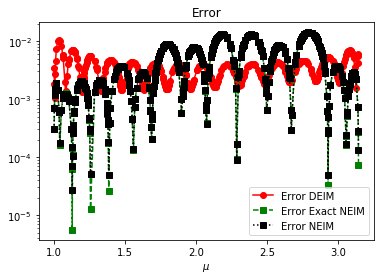

[0, 13, 30, 50, 6, 21, 39, 3, 25, 45, 16, 35, 9, 48, 1, 42, 27, 18, 49, 4]
0 Max Error: 29.330188202753714 Mean Error: 17.993265559847828
0 0.595128580793031
100 0.3514092101201393
200 0.2442878385421546
300 0.17002997632369393
400 0.10603880367760649
500 0.05758883116185102
600 0.027561727731830684
700 0.011928048678768068
800 0.004777966678171635
900 0.0017954930260358159
1000 0.0006359814568928513
1100 0.00021236448843598582
1200 6.671972457835711e-05
1300 1.9662451657103135e-05
1400 5.415514324500254e-06
1500 1.3884824064927113e-06
1600 3.3005203373807914e-07
1700 7.24574819108662e-08
1800 1.4651211664814676e-08
1900 2.739771644526438e-09
2000 4.942499580609444e-10
2100 1.0695646278678712e-10
2200 4.440221905975477e-11
2300 3.3390669166701986e-11
2400 2.998379783218557e-11
2500 2.7812763086345653e-11
2600 2.6023851184358895e-11
2700 2.448677346092423e-11
2800 2.3158592298667233e-11
2900 2.200902603020603e-11
3000 2.1012422320171367e-11
3100 2.014664984679389e-11
3200 1.939263737011

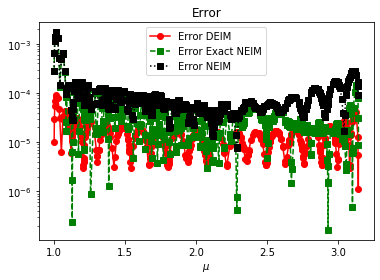

[0, 13, 30, 50, 6, 21, 39, 3, 25, 45, 16, 35, 9, 48, 1, 42, 27, 18, 49, 4, 33, 11, 47, 2, 37]
0 Max Error: 29.330188202753714 Mean Error: 17.993265559847828
0 0.3198670958706386
100 0.21230071946888768
200 0.1330397695576842
300 0.07319755502915129
400 0.03639811224961203
500 0.01689673884918381
600 0.007457810744398166
700 0.0031432371261083613
800 0.0013165109689114197
900 0.0006071481213979448
1000 0.00034491076972650083
1100 0.00023889722191406697
1200 0.00017930528748056425
1300 0.00013024077667271662
1400 8.377018923936367e-05
1500 4.479143750638215e-05
1600 2.0560270285099105e-05
1700 9.33471971828892e-06
1800 4.630442082404766e-06
1900 2.542249631289473e-06
2000 1.5275198886310973e-06
2100 9.882413212271914e-07
2200 6.74090476438378e-07
2300 4.749710122869554e-07
2400 3.404945850639195e-07
2500 2.4601737587532335e-07
2600 1.7821290088175025e-07
2700 1.2904628744859517e-07
2800 9.324074488257881e-08
2900 6.714325315808047e-08
3000 4.815093913316267e-08
3100 3.4378622101442444e-0

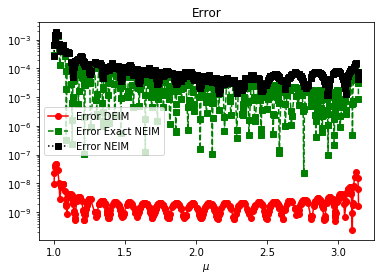

[0, 13, 30, 50, 6, 21, 39, 3, 25, 45, 16, 35, 9, 48, 1, 42, 27, 18, 49, 4, 33, 11, 47, 2, 37, 44, 7, 23, 46, 14]
0 Max Error: 29.330188202753714 Mean Error: 17.993265559847828
0 0.4352360969617741
100 0.3125288492041087
200 0.2044205371588866
300 0.12297853571144166
400 0.0699326252072504
500 0.03788804957284309
600 0.019512386719009053
700 0.009556241554051896
800 0.004468342915334383
900 0.001997120271296869
1000 0.0008509864959981792
1100 0.0003444252119646642
1200 0.0001319854024580974
1300 4.775664811408926e-05
1400 1.6271832735710575e-05
1500 5.2044941592425e-06
1600 1.556958607743473e-06
1700 4.3390080861307975e-07
1800 1.1221107842246741e-07
1900 2.6865156448245686e-08
2000 5.980412499087547e-09
2100 1.2808979993975736e-09
2200 3.0837200420432616e-10
2300 1.2139489909983788e-10
2400 8.630729220195533e-11
2500 7.849207223232869e-11
2600 7.540578852051693e-11
2700 7.320879922314903e-11
2800 7.124955960730574e-11
2900 6.940495539169345e-11
3000 6.76448698204721e-11
3100 6.59586198

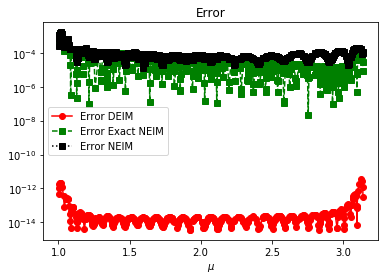

In [9]:
MAX_MODES = 30
NUM_TRAIN_PARAMS = 51
NUM_SPATIAL_POINTS = 100
x = np.linspace(-1, 1, NUM_SPATIAL_POINTS).reshape(-1,1)
mu = np.linspace(1, np.pi, NUM_TRAIN_PARAMS).reshape(-1,1).T
f = s(x, mu)

u, sing_vals, vh = np.linalg.svd(f, full_matrices=True)

RO_DIM = 30

# find solution to Poisson with homogeneous Dirichlet boundary conditions
# -u''(x; mu) = s(x; mu), u(0; mu) = u(1; mu) = 0.

sols = solution_fn(mu.reshape(-1), f) # shape = (params, space)

# do a POD based on sols
snapshots = np.array([sols[i] for i in range(sols.shape[0])]).T
V, sing_vals, _ = np.linalg.svd(snapshots, full_matrices=False)

# get reduced order solutions
ro_sols = np.zeros((sols.shape[0], RO_DIM))
for i in range(sols.shape[0]):
    ro_sols[i] = (V[:,:RO_DIM].T @ sols[i].reshape(-1, 1)).reshape(-1)

# evaluate nonlinearity at given parameter and solution
f_NEIM = np.zeros((sols.shape[0], sols.shape[0], RO_DIM))
for i in range(sols.shape[0]):
    for j in range(sols.shape[0]):
        f_NEIM[i, j] = (V[:,:RO_DIM].T @ f[:, [i]]).reshape(-1)

test_mu = np.sort(np.random.uniform(size=500)*(np.pi-1)+1)
DEIM_errors = []
Exact_NEIM_errors = []
Actual_NEIM_errors = []
for num_modes in range(5, MAX_MODES+1, 5):
    s_op = np.zeros((f.shape[0], num_modes)) # selection operator
    for i, idx in enumerate(DEIM(u)[:num_modes]):
        s_op[idx, i] = 1
    DEIM_proj = u[:, :num_modes] @ np.linalg.inv(s_op.T @ u[:, :num_modes]) @ s_op.T # DEIM projection
    Exact_NEIM_approximation, Exact_NEIM_selected_indices = Exact_NEIM(mu.reshape(-1), f, V[:, :RO_DIM], num_modes)
    print(Exact_NEIM_selected_indices)
    NEIM_approximation, NEIM_selected_indices = NEIM(ro_sols, f_NEIM, mu.reshape(-1), V[:, :RO_DIM], max_modes=num_modes, train_loop_iterations=20000) 
    print(NEIM_selected_indices)
    
    exact = V[:, :RO_DIM].T @ s(x, test_mu)
    DEIM_approximation = V[:, :RO_DIM].T @ DEIM_proj @ s(x, test_mu)
    Degenerate_NEIM_approximation = np.array([V[:, :RO_DIM].T @ Exact_NEIM_approximation(new_mu, num_modes) for new_mu in test_mu.reshape(-1)])[:, :, 0].T
    Actual_NEIM_approximation = np.array([V[:, :RO_DIM].T @ NEIM_approximation(new_mu, (V[:, :RO_DIM].T @ solution_fn(np.array([[new_mu]]), s(x, new_mu)).reshape(-1, 1)).reshape(-1), num_modes) for new_mu in test_mu.reshape(-1)]).T
    
    avg_error = np.mean([np.linalg.norm(exact[:, i] - DEIM_approximation[:, i]) for i in range(exact.shape[1])])
    DEIM_errors.append(avg_error)
    avg_error = np.mean([np.linalg.norm(exact[:, i] - Degenerate_NEIM_approximation[:, i]) for i in range(exact.shape[1])])
    Exact_NEIM_errors.append(avg_error)
    avg_error = np.mean([np.linalg.norm(exact[:, i] - Actual_NEIM_approximation[:, i]) for i in range(exact.shape[1])])
    Actual_NEIM_errors.append(avg_error)
    
    plt.plot(test_mu.reshape(-1), [np.linalg.norm(exact[:, i] - DEIM_approximation[:, i]) for i in range(exact.shape[1])], marker='o', c='r', label="Error DEIM")
    plt.plot(test_mu.reshape(-1), [np.linalg.norm(exact[:, i] - Degenerate_NEIM_approximation[:, i]) for i in range(exact.shape[1])], marker='s', c='g', linestyle='dashed', label="Error Exact NEIM")
    plt.plot(test_mu.reshape(-1), [np.linalg.norm(exact[:, i] - Actual_NEIM_approximation[:, i]) for i in range(exact.shape[1])], marker='s', c='black', linestyle='dotted', label="Error NEIM")
    plt.yscale("log")
    plt.legend()
    plt.xlabel("$\mu$")
    plt.title("Error")
    plt.show()

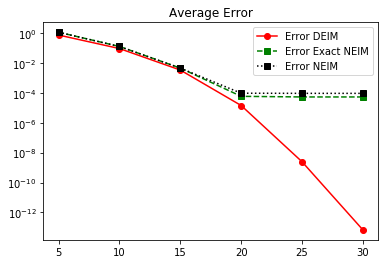

In [10]:
plt.plot(np.arange(5, MAX_MODES+1, 5), DEIM_errors, marker='o', c='r', label="Error DEIM")
plt.plot(np.arange(5, MAX_MODES+1, 5), Exact_NEIM_errors, marker='s', c='g', linestyle='dashed', label="Error Exact NEIM")
plt.plot(np.arange(5, MAX_MODES+1, 5), Actual_NEIM_errors, marker='s', c='black', linestyle='dotted', label="Error NEIM")
plt.yscale("log")
plt.legend()
plt.title("Average Error")
plt.show()